In [1]:
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow import keras
import seaborn as sns

from os.path import join

plt.style.use(["seaborn", "thesis"])

/home/jo/anaconda3/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


In [2]:
plt.rc("figure", figsize=(8,4))

# Fetch Dataset 

In [3]:
from SCFInitialGuess.utilities.dataset import Data

target = "P"

data = Data()

data.include(data_path = "../../dataset/MethanT/", postfix = "MethanT", target=target)
data.include(data_path = "../../dataset/MethanT2/", postfix = "MethanT2", target=target)
data.include(data_path = "../../dataset/MethanT3/", postfix = "MethanT3", target=target)
data.include(data_path = "../../dataset/MethanT4/", postfix = "MethanT4", target=target)

data.include(data_path = "../../dataset/EthanT/",  postfix = "EthanT", target=target)
data.include(data_path = "../../dataset/EthanT2/", postfix = "EthanT2", target=target)
data.include(data_path = "../../dataset/EthanT3/", postfix = "EthanT3", target=target)

data.include(data_path = "../../dataset/EthenT/",  postfix = "EthenT", target=target)
data.include(data_path = "../../dataset/EthenT2/", postfix = "EthenT2", target=target)
data.include(data_path = "../../dataset/EthenT3/", postfix = "EthenT3", target=target)

data.include(data_path = "../../dataset/EthinT/",  postfix = "EthinT", target=target)
data.include(data_path = "../../dataset/EthinT2/", postfix = "EthinT2", target=target)
data.include(data_path = "../../dataset/EthinT3/", postfix = "EthinT3", target=target)

#data.include(data_path = "../../dataset/QM9/", postfix = "QM9-300")

# SetUp descriptor And Normalisation

In [4]:
import pickle

model_path = "../../models/Descriptor"
target = "P"

descriptor_C = pickle.load(open(model_path + "C/" + target + "/descriptor.dump", "rb"))
descriptor_H = pickle.load(open(model_path + "H/" + target + "/descriptor.dump", "rb"))

descriptors = {
    "C": descriptor_C,
    "H": descriptor_H
}

In [5]:
descriptor_H

In [6]:
normalisations = {
    "C": np.load(model_path + "C/" + target + "/normalisation.npy"),
    "H": np.load(model_path + "H/" + target + "/normalisation.npy")
}

# Fetch Networks 

In [7]:
path = model_path

name_C = model_path + "C/" + target + "/C_" + target + ".h5"
name_H = model_path + "H/" + target + "/H_" + target + ".h5"


model_C = keras.models.load_model(name_C)
model_H = keras.models.load_model(name_H)

networks = {
    "C": model_C,
    "H": model_H
}

# Guess Method 

In [8]:
from SCFInitialGuess.utilities.dataset import reconstruct_from_triu, AbstractDataset
from SCFInitialGuess.utilities.constants import number_of_basis_functions as N_BASIS
from pyscf.scf.hf import init_guess_by_wolfsberg_helmholtz


def init_guess_by_ann(mol):
    
    p  = init_guess_by_wolfsberg_helmholtz(mol.get_pyscf_molecule()).copy() # TODO set up my own GWH in SCFInitialGuess
    
    for atom_index, atom in enumerate(mol.species):
        
        mask = mol.make_atom_mask(atom_index)
        
        
        G = descriptors[atom].calculate_atom_descriptor(
            atom_index, 
            mol,
            descriptors[atom].number_of_descriptors
        )
        
        G_norm = AbstractDataset.normalize(G, *normalisations[atom])
        
        #f(G)
        f = networks[atom].predict(G.reshape(1, -1))
        
        f_batch = reconstruct_from_triu(
            f,
            N_BASIS[mol.basis][atom]
        )
        
        p[mask] = f_batch.flatten()
        
    return p
        
    

# Analysis 

## Utils 

In [9]:
from SCFInitialGuess.utilities.dataset import StaticDataset

dataset = StaticDataset(
    #train=(s_train, p_train),
    train=(data.S[0], data.T[0]),
    validation=(data.S[1], data.T[1]),
    test=(data.S[2], data.T[2]),
    mu=0,
    std=1
)

 ## Execution 

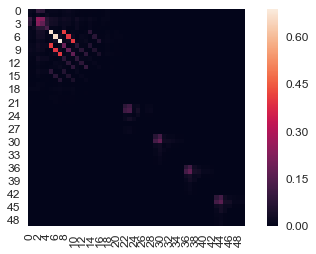

In [10]:
sns.heatmap(np.abs(init_guess_by_ann(data.molecules[2][0]) \
                   - init_guess_by_wolfsberg_helmholtz(data.molecules[2][0].get_pyscf_molecule())), square=True)

In [11]:
p_nn = np.array([
    init_guess_by_ann(mol) for mol in data.molecules[2]
])

In [12]:
np.save("data/p_nn.npy", p_nn)

In [4]:
p_nn = np.load("data/p_nn.npy")

# Scatter 

In [5]:
plt.rc("figure", figsize=(6,5))

In [14]:
def flatten(x):
    y = []
    for xi in x:
        y += list(xi.flatten())
    return y

p_exp = flatten(data.T[2])
p_nn_flatten = flatten(p_nn)

In [30]:
ind = np.arange(len(p_exp))
np.random.shuffle(ind)
print(len(p_exp), len(p_nn_flatten))

9767440 9767440


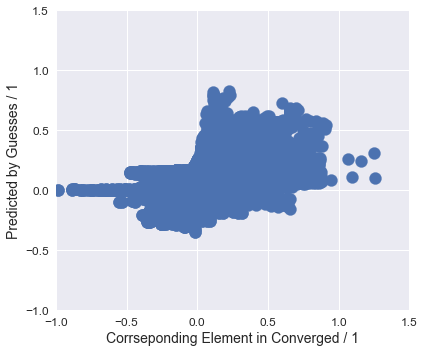

In [17]:
n_max = len(p_exp)
plt.scatter(
    np.array(p_exp),#[ind[:n_max]], 
    np.array(p_nn_flatten),#[ind[:n_max]]
)

plt.xlim(-1, 1.5)
plt.ylim(-1, 1.5)

plt.xlabel("Corrseponding Element in Converged / 1")
plt.ylabel("Predicted by Guesses / 1")

plt.tight_layout()

plt.show()

## Pure 

In [8]:
from SCFInitialGuess.utilities.analysis import mf_initializer
from SCFInitialGuess.utilities.analysis import measure_iterations
from SCFInitialGuess.utilities.usermessages import Messenger as msg
msg.print_level = 3

    
iterations = np.array(measure_iterations(
    mf_initializer, 
    p_nn, 
    data.molecules[2]
))

max_cycle = mf_initializer(
    data.molecules[2][0].get_pyscf_molecule()
).max_cycle


[ ] 2018-12-10 18:19:03: Iteration calculation: 0
[ ] 2018-12-10 18:19:03: Iteration calculation: 1
[ ] 2018-12-10 18:19:03: Iteration calculation: 2
[ ] 2018-12-10 18:19:03: Iteration calculation: 3
[ ] 2018-12-10 18:19:03: Iteration calculation: 4
[ ] 2018-12-10 18:19:04: Iteration calculation: 5
[ ] 2018-12-10 18:19:04: Iteration calculation: 6
[ ] 2018-12-10 18:19:04: Iteration calculation: 7
[ ] 2018-12-10 18:19:04: Iteration calculation: 8
[ ] 2018-12-10 18:19:04: Iteration calculation: 9
[ ] 2018-12-10 18:19:04: Iteration calculation: 10
[ ] 2018-12-10 18:19:05: Iteration calculation: 11
[ ] 2018-12-10 18:19:05: Iteration calculation: 12
[ ] 2018-12-10 18:19:05: Iteration calculation: 13
[ ] 2018-12-10 18:19:05: Iteration calculation: 14
[ ] 2018-12-10 18:19:05: Iteration calculation: 15
[ ] 2018-12-10 18:19:05: Iteration calculation: 16
[ ] 2018-12-10 18:19:06: Iteration calculation: 17
[ ] 2018-12-10 18:19:06: Iteration calculation: 18
[ ] 2018-12-10 18:19:06: Iteration calcul

[ ] 2018-12-10 18:19:30: Iteration calculation: 161
[ ] 2018-12-10 18:19:30: Iteration calculation: 162
[ ] 2018-12-10 18:19:30: Iteration calculation: 163
[ ] 2018-12-10 18:19:30: Iteration calculation: 164
[ ] 2018-12-10 18:19:30: Iteration calculation: 165
[ ] 2018-12-10 18:19:31: Iteration calculation: 166
[ ] 2018-12-10 18:19:31: Iteration calculation: 167
[ ] 2018-12-10 18:19:31: Iteration calculation: 168
[ ] 2018-12-10 18:19:31: Iteration calculation: 169
[ ] 2018-12-10 18:19:31: Iteration calculation: 170
[ ] 2018-12-10 18:19:31: Iteration calculation: 171
[ ] 2018-12-10 18:19:31: Iteration calculation: 172
[ ] 2018-12-10 18:19:32: Iteration calculation: 173
[ ] 2018-12-10 18:19:32: Iteration calculation: 174
[ ] 2018-12-10 18:19:32: Iteration calculation: 175
[ ] 2018-12-10 18:19:32: Iteration calculation: 176
[ ] 2018-12-10 18:19:32: Iteration calculation: 177
[ ] 2018-12-10 18:19:32: Iteration calculation: 178
[ ] 2018-12-10 18:19:33: Iteration calculation: 179
[ ] 2018-12-

[ ] 2018-12-10 18:20:10: Iteration calculation: 320
[ ] 2018-12-10 18:20:11: Iteration calculation: 321
[ ] 2018-12-10 18:20:11: Iteration calculation: 322
[ ] 2018-12-10 18:20:11: Iteration calculation: 323
[ ] 2018-12-10 18:20:11: Iteration calculation: 324
[ ] 2018-12-10 18:20:11: Iteration calculation: 325
[ ] 2018-12-10 18:20:11: Iteration calculation: 326
[ ] 2018-12-10 18:20:12: Iteration calculation: 327
[ ] 2018-12-10 18:20:12: Iteration calculation: 328
[ ] 2018-12-10 18:20:12: Iteration calculation: 329
[ ] 2018-12-10 18:20:12: Iteration calculation: 330
[ ] 2018-12-10 18:20:12: Iteration calculation: 331
[ ] 2018-12-10 18:20:13: Iteration calculation: 332
[ ] 2018-12-10 18:20:13: Iteration calculation: 333
[ ] 2018-12-10 18:20:13: Iteration calculation: 334
[ ] 2018-12-10 18:20:13: Iteration calculation: 335
[ ] 2018-12-10 18:20:13: Iteration calculation: 336
[ ] 2018-12-10 18:20:13: Iteration calculation: 337
[ ] 2018-12-10 18:20:14: Iteration calculation: 338
[ ] 2018-12-

[ ] 2018-12-10 18:20:37: Iteration calculation: 479
[ ] 2018-12-10 18:20:37: Iteration calculation: 480
[ ] 2018-12-10 18:20:37: Iteration calculation: 481
[ ] 2018-12-10 18:20:37: Iteration calculation: 482
[ ] 2018-12-10 18:20:37: Iteration calculation: 483
[ ] 2018-12-10 18:20:38: Iteration calculation: 484
[ ] 2018-12-10 18:20:38: Iteration calculation: 485
[ ] 2018-12-10 18:20:38: Iteration calculation: 486
[ ] 2018-12-10 18:20:38: Iteration calculation: 487
[ ] 2018-12-10 18:20:38: Iteration calculation: 488
[ ] 2018-12-10 18:20:38: Iteration calculation: 489
[ ] 2018-12-10 18:20:39: Iteration calculation: 490
[ ] 2018-12-10 18:20:39: Iteration calculation: 491
[ ] 2018-12-10 18:20:39: Iteration calculation: 492
[ ] 2018-12-10 18:20:39: Iteration calculation: 493
[ ] 2018-12-10 18:20:39: Iteration calculation: 494
[ ] 2018-12-10 18:20:40: Iteration calculation: 495
[ ] 2018-12-10 18:20:40: Iteration calculation: 496
[ ] 2018-12-10 18:20:40: Iteration calculation: 497
[ ] 2018-12-

[ ] 2018-12-10 18:22:12: Iteration calculation: 637
[ ] 2018-12-10 18:22:13: Iteration calculation: 638
[ ] 2018-12-10 18:22:13: Iteration calculation: 639
[ ] 2018-12-10 18:22:14: Iteration calculation: 640
[ ] 2018-12-10 18:22:15: Iteration calculation: 641
[ ] 2018-12-10 18:22:16: Iteration calculation: 642
[ ] 2018-12-10 18:22:16: Iteration calculation: 643
[ ] 2018-12-10 18:22:17: Iteration calculation: 644
[ ] 2018-12-10 18:22:18: Iteration calculation: 645
[ ] 2018-12-10 18:22:19: Iteration calculation: 646
[ ] 2018-12-10 18:22:19: Iteration calculation: 647
[ ] 2018-12-10 18:22:20: Iteration calculation: 648
[ ] 2018-12-10 18:22:21: Iteration calculation: 649
[ ] 2018-12-10 18:22:21: Iteration calculation: 650
[ ] 2018-12-10 18:22:22: Iteration calculation: 651
[ ] 2018-12-10 18:22:23: Iteration calculation: 652
[ ] 2018-12-10 18:22:23: Iteration calculation: 653
[ ] 2018-12-10 18:22:24: Iteration calculation: 654
[ ] 2018-12-10 18:22:25: Iteration calculation: 655
[ ] 2018-12-

[ ] 2018-12-10 18:24:10: Iteration calculation: 795
[ ] 2018-12-10 18:24:10: Iteration calculation: 796
[ ] 2018-12-10 18:24:11: Iteration calculation: 797
[ ] 2018-12-10 18:24:11: Iteration calculation: 798
[ ] 2018-12-10 18:24:12: Iteration calculation: 799
[ ] 2018-12-10 18:24:13: Iteration calculation: 800
[ ] 2018-12-10 18:24:13: Iteration calculation: 801
[ ] 2018-12-10 18:24:14: Iteration calculation: 802
[ ] 2018-12-10 18:24:14: Iteration calculation: 803
[ ] 2018-12-10 18:24:15: Iteration calculation: 804
[ ] 2018-12-10 18:24:16: Iteration calculation: 805
[ ] 2018-12-10 18:24:16: Iteration calculation: 806
[ ] 2018-12-10 18:24:17: Iteration calculation: 807
[ ] 2018-12-10 18:24:18: Iteration calculation: 808
[ ] 2018-12-10 18:24:19: Iteration calculation: 809
[ ] 2018-12-10 18:24:19: Iteration calculation: 810
[ ] 2018-12-10 18:24:20: Iteration calculation: 811
[ ] 2018-12-10 18:24:21: Iteration calculation: 812
[ ] 2018-12-10 18:24:22: Iteration calculation: 813
[ ] 2018-12-

[ ] 2018-12-10 18:26:32: Iteration calculation: 953
[ ] 2018-12-10 18:26:34: Iteration calculation: 954
[ ] 2018-12-10 18:26:36: Iteration calculation: 955
[ ] 2018-12-10 18:26:38: Iteration calculation: 956
[ ] 2018-12-10 18:26:40: Iteration calculation: 957
[ ] 2018-12-10 18:26:42: Iteration calculation: 958
[ ] 2018-12-10 18:26:43: Iteration calculation: 959
[ ] 2018-12-10 18:26:45: Iteration calculation: 960
[ ] 2018-12-10 18:26:47: Iteration calculation: 961
[ ] 2018-12-10 18:26:49: Iteration calculation: 962
[ ] 2018-12-10 18:26:51: Iteration calculation: 963
[ ] 2018-12-10 18:26:53: Iteration calculation: 964
[ ] 2018-12-10 18:26:54: Iteration calculation: 965
[ ] 2018-12-10 18:26:55: Iteration calculation: 966
[ ] 2018-12-10 18:26:56: Iteration calculation: 967
[ ] 2018-12-10 18:26:57: Iteration calculation: 968
[ ] 2018-12-10 18:26:58: Iteration calculation: 969
[ ] 2018-12-10 18:26:59: Iteration calculation: 970
[ ] 2018-12-10 18:27:00: Iteration calculation: 971
[ ] 2018-12-

[ ] 2018-12-10 18:28:56: Iteration calculation: 1109
[ ] 2018-12-10 18:28:56: Iteration calculation: 1110
[ ] 2018-12-10 18:28:57: Iteration calculation: 1111
[ ] 2018-12-10 18:28:57: Iteration calculation: 1112
[ ] 2018-12-10 18:28:58: Iteration calculation: 1113
[ ] 2018-12-10 18:28:59: Iteration calculation: 1114
[ ] 2018-12-10 18:28:59: Iteration calculation: 1115
[ ] 2018-12-10 18:29:00: Iteration calculation: 1116
[ ] 2018-12-10 18:29:01: Iteration calculation: 1117
[ ] 2018-12-10 18:29:01: Iteration calculation: 1118
[ ] 2018-12-10 18:29:02: Iteration calculation: 1119
[ ] 2018-12-10 18:29:02: Iteration calculation: 1120
[ ] 2018-12-10 18:29:02: Iteration calculation: 1121
[ ] 2018-12-10 18:29:03: Iteration calculation: 1122
[ ] 2018-12-10 18:29:03: Iteration calculation: 1123
[ ] 2018-12-10 18:29:04: Iteration calculation: 1124
[ ] 2018-12-10 18:29:04: Iteration calculation: 1125
[ ] 2018-12-10 18:29:05: Iteration calculation: 1126
[ ] 2018-12-10 18:29:06: Iteration calculation

[ ] 2018-12-10 18:30:58: Iteration calculation: 1264
[ ] 2018-12-10 18:30:59: Iteration calculation: 1265
[ ] 2018-12-10 18:31:01: Iteration calculation: 1266
[ ] 2018-12-10 18:31:02: Iteration calculation: 1267
[ ] 2018-12-10 18:31:03: Iteration calculation: 1268
[ ] 2018-12-10 18:31:03: Iteration calculation: 1269
[ ] 2018-12-10 18:31:05: Iteration calculation: 1270
[ ] 2018-12-10 18:31:06: Iteration calculation: 1271
[ ] 2018-12-10 18:31:08: Iteration calculation: 1272
[ ] 2018-12-10 18:31:09: Iteration calculation: 1273
[ ] 2018-12-10 18:31:11: Iteration calculation: 1274
[ ] 2018-12-10 18:31:12: Iteration calculation: 1275
[ ] 2018-12-10 18:31:13: Iteration calculation: 1276
[ ] 2018-12-10 18:31:15: Iteration calculation: 1277
[ ] 2018-12-10 18:31:16: Iteration calculation: 1278
[ ] 2018-12-10 18:31:17: Iteration calculation: 1279
[ ] 2018-12-10 18:31:18: Iteration calculation: 1280
[ ] 2018-12-10 18:31:19: Iteration calculation: 1281
[ ] 2018-12-10 18:31:20: Iteration calculation

[ ] 2018-12-10 18:33:52: Iteration calculation: 1419
[ ] 2018-12-10 18:33:54: Iteration calculation: 1420
[ ] 2018-12-10 18:33:55: Iteration calculation: 1421
[ ] 2018-12-10 18:33:56: Iteration calculation: 1422
[ ] 2018-12-10 18:33:58: Iteration calculation: 1423
[ ] 2018-12-10 18:34:01: Iteration calculation: 1424
[ ] 2018-12-10 18:34:03: Iteration calculation: 1425
[ ] 2018-12-10 18:34:04: Iteration calculation: 1426
[ ] 2018-12-10 18:34:05: Iteration calculation: 1427
[ ] 2018-12-10 18:34:06: Iteration calculation: 1428
[ ] 2018-12-10 18:34:07: Iteration calculation: 1429
[ ] 2018-12-10 18:34:07: Iteration calculation: 1430
[ ] 2018-12-10 18:34:08: Iteration calculation: 1431
[ ] 2018-12-10 18:34:09: Iteration calculation: 1432
[ ] 2018-12-10 18:34:09: Iteration calculation: 1433
[ ] 2018-12-10 18:34:10: Iteration calculation: 1434
[ ] 2018-12-10 18:34:10: Iteration calculation: 1435
[ ] 2018-12-10 18:34:11: Iteration calculation: 1436
[ ] 2018-12-10 18:34:12: Iteration calculation

[ ] 2018-12-10 18:37:13: Iteration calculation: 1574
[ ] 2018-12-10 18:37:14: Iteration calculation: 1575
[ ] 2018-12-10 18:37:15: Iteration calculation: 1576
[ ] 2018-12-10 18:37:15: Iteration calculation: 1577
[ ] 2018-12-10 18:37:16: Iteration calculation: 1578
[ ] 2018-12-10 18:37:16: Iteration calculation: 1579
[ ] 2018-12-10 18:37:17: Iteration calculation: 1580
[ ] 2018-12-10 18:37:18: Iteration calculation: 1581
[ ] 2018-12-10 18:37:18: Iteration calculation: 1582
[ ] 2018-12-10 18:37:19: Iteration calculation: 1583
[ ] 2018-12-10 18:37:20: Iteration calculation: 1584
[ ] 2018-12-10 18:37:21: Iteration calculation: 1585
[ ] 2018-12-10 18:37:22: Iteration calculation: 1586
[ ] 2018-12-10 18:37:22: Iteration calculation: 1587
[ ] 2018-12-10 18:37:23: Iteration calculation: 1588
[ ] 2018-12-10 18:37:23: Iteration calculation: 1589
[ ] 2018-12-10 18:37:24: Iteration calculation: 1590
[ ] 2018-12-10 18:37:25: Iteration calculation: 1591
[ ] 2018-12-10 18:37:25: Iteration calculation

[ ] 2018-12-10 18:39:18: Iteration calculation: 1729
[ ] 2018-12-10 18:39:19: Iteration calculation: 1730
[ ] 2018-12-10 18:39:19: Iteration calculation: 1731
[ ] 2018-12-10 18:39:20: Iteration calculation: 1732
[ ] 2018-12-10 18:39:20: Iteration calculation: 1733
[ ] 2018-12-10 18:39:20: Iteration calculation: 1734
[ ] 2018-12-10 18:39:21: Iteration calculation: 1735
[ ] 2018-12-10 18:39:22: Iteration calculation: 1736
[ ] 2018-12-10 18:39:23: Iteration calculation: 1737
[ ] 2018-12-10 18:39:24: Iteration calculation: 1738
[ ] 2018-12-10 18:39:25: Iteration calculation: 1739
[ ] 2018-12-10 18:39:26: Iteration calculation: 1740
[ ] 2018-12-10 18:39:27: Iteration calculation: 1741
[ ] 2018-12-10 18:39:27: Iteration calculation: 1742
[ ] 2018-12-10 18:39:28: Iteration calculation: 1743
[ ] 2018-12-10 18:39:29: Iteration calculation: 1744
[ ] 2018-12-10 18:39:30: Iteration calculation: 1745
[ ] 2018-12-10 18:39:31: Iteration calculation: 1746
[ ] 2018-12-10 18:39:33: Iteration calculation

[ ] 2018-12-10 18:41:35: Iteration calculation: 1884
[ ] 2018-12-10 18:41:35: Iteration calculation: 1885
[ ] 2018-12-10 18:41:36: Iteration calculation: 1886
[ ] 2018-12-10 18:41:36: Iteration calculation: 1887
[ ] 2018-12-10 18:41:37: Iteration calculation: 1888
[ ] 2018-12-10 18:41:37: Iteration calculation: 1889
[ ] 2018-12-10 18:41:37: Iteration calculation: 1890
[ ] 2018-12-10 18:41:38: Iteration calculation: 1891
[ ] 2018-12-10 18:41:39: Iteration calculation: 1892
[ ] 2018-12-10 18:41:39: Iteration calculation: 1893
[ ] 2018-12-10 18:41:40: Iteration calculation: 1894
[ ] 2018-12-10 18:41:41: Iteration calculation: 1895
[ ] 2018-12-10 18:41:41: Iteration calculation: 1896
[ ] 2018-12-10 18:41:42: Iteration calculation: 1897
[ ] 2018-12-10 18:41:42: Iteration calculation: 1898
[ ] 2018-12-10 18:41:43: Iteration calculation: 1899
[ ] 2018-12-10 18:41:44: Iteration calculation: 1900
[ ] 2018-12-10 18:41:46: Iteration calculation: 1901
[ ] 2018-12-10 18:41:46: Iteration calculation

[ ] 2018-12-10 18:43:35: Iteration calculation: 2039
[ ] 2018-12-10 18:43:35: Iteration calculation: 2040
[ ] 2018-12-10 18:43:36: Iteration calculation: 2041
[ ] 2018-12-10 18:43:37: Iteration calculation: 2042
[ ] 2018-12-10 18:43:38: Iteration calculation: 2043
[ ] 2018-12-10 18:43:39: Iteration calculation: 2044
[ ] 2018-12-10 18:43:40: Iteration calculation: 2045
[ ] 2018-12-10 18:43:41: Iteration calculation: 2046
[ ] 2018-12-10 18:43:41: Iteration calculation: 2047
[ ] 2018-12-10 18:43:42: Iteration calculation: 2048
[ ] 2018-12-10 18:43:43: Iteration calculation: 2049
[ ] 2018-12-10 18:43:44: Iteration calculation: 2050
[ ] 2018-12-10 18:43:45: Iteration calculation: 2051
[ ] 2018-12-10 18:43:46: Iteration calculation: 2052
[ ] 2018-12-10 18:43:47: Iteration calculation: 2053
[ ] 2018-12-10 18:43:48: Iteration calculation: 2054
[ ] 2018-12-10 18:43:49: Iteration calculation: 2055
[ ] 2018-12-10 18:43:51: Iteration calculation: 2056
[ ] 2018-12-10 18:43:53: Iteration calculation

In [10]:
from SCFInitialGuess.utilities.analysis import statistics

print(statistics(iterations))
print(statistics(iterations[iterations != max_cycle]))
print(np.sum(max_cycle == np.array(iterations)))


(45.44360547428032, 31.871194067014184)
(30.982089552238804, 16.938862191723192)
444


## Damping 

In [11]:
from SCFInitialGuess.utilities.analysis import mf_initializer_damping as mf_initializer
from SCFInitialGuess.utilities.analysis import measure_iterations
from SCFInitialGuess.utilities.usermessages import Messenger as msg


    
iterations = np.array(measure_iterations(
    mf_initializer, 
    p_nn, 
    data.molecules[2]
))

max_cycle = mf_initializer(
    data.molecules[2][0].get_pyscf_molecule()
).max_cycle

print(statistics(iterations))
print(statistics(iterations[iterations != max_cycle]))
print(np.sum(max_cycle == np.array(iterations)))

(35.773478055686645, 26.021783351823075)
(27.221390374331552, 12.036938344025664)
249


## DIIS 

In [15]:
from SCFInitialGuess.utilities.analysis import mf_initializer_diis as mf_initializer
from SCFInitialGuess.utilities.analysis import measure_iterations
from SCFInitialGuess.utilities.usermessages import Messenger as msg


    
iterations = np.array(measure_iterations(
    mf_initializer, 
    p_nn, 
    data.molecules[2]
))

max_cycle = mf_initializer(
    data.molecules[2][0].get_pyscf_molecule()
).max_cycle

print(statistics(iterations))
print(statistics(iterations[iterations != max_cycle]))
print(np.sum(max_cycle == np.array(iterations)))

[ ] 2018-12-10 19:38:55: Iteration calculation: 0
[ ] 2018-12-10 19:38:55: Iteration calculation: 1
[ ] 2018-12-10 19:38:55: Iteration calculation: 2
[ ] 2018-12-10 19:38:55: Iteration calculation: 3
[ ] 2018-12-10 19:38:55: Iteration calculation: 4
[ ] 2018-12-10 19:38:56: Iteration calculation: 5
[ ] 2018-12-10 19:38:56: Iteration calculation: 6
[ ] 2018-12-10 19:38:57: Iteration calculation: 7
[ ] 2018-12-10 19:38:57: Iteration calculation: 8
[ ] 2018-12-10 19:38:57: Iteration calculation: 9
[ ] 2018-12-10 19:38:57: Iteration calculation: 10
[ ] 2018-12-10 19:38:58: Iteration calculation: 11
[ ] 2018-12-10 19:38:58: Iteration calculation: 12
[ ] 2018-12-10 19:38:58: Iteration calculation: 13
[ ] 2018-12-10 19:38:58: Iteration calculation: 14
[ ] 2018-12-10 19:38:59: Iteration calculation: 15
[ ] 2018-12-10 19:38:59: Iteration calculation: 16
[ ] 2018-12-10 19:38:59: Iteration calculation: 17
[ ] 2018-12-10 19:38:59: Iteration calculation: 18
[ ] 2018-12-10 19:39:00: Iteration calcul

[ ] 2018-12-10 19:39:26: Iteration calculation: 161
[ ] 2018-12-10 19:39:26: Iteration calculation: 162
[ ] 2018-12-10 19:39:26: Iteration calculation: 163
[ ] 2018-12-10 19:39:27: Iteration calculation: 164
[ ] 2018-12-10 19:39:27: Iteration calculation: 165
[ ] 2018-12-10 19:39:27: Iteration calculation: 166
[ ] 2018-12-10 19:39:27: Iteration calculation: 167
[ ] 2018-12-10 19:39:28: Iteration calculation: 168
[ ] 2018-12-10 19:39:28: Iteration calculation: 169
[ ] 2018-12-10 19:39:28: Iteration calculation: 170
[ ] 2018-12-10 19:39:28: Iteration calculation: 171
[ ] 2018-12-10 19:39:28: Iteration calculation: 172
[ ] 2018-12-10 19:39:29: Iteration calculation: 173
[ ] 2018-12-10 19:39:29: Iteration calculation: 174
[ ] 2018-12-10 19:39:29: Iteration calculation: 175
[ ] 2018-12-10 19:39:29: Iteration calculation: 176
[ ] 2018-12-10 19:39:29: Iteration calculation: 177
[ ] 2018-12-10 19:39:30: Iteration calculation: 178
[ ] 2018-12-10 19:39:30: Iteration calculation: 179
[ ] 2018-12-

[ ] 2018-12-10 19:40:12: Iteration calculation: 319
[ ] 2018-12-10 19:40:13: Iteration calculation: 320
[ ] 2018-12-10 19:40:13: Iteration calculation: 321
[ ] 2018-12-10 19:40:13: Iteration calculation: 322
[ ] 2018-12-10 19:40:13: Iteration calculation: 323
[ ] 2018-12-10 19:40:14: Iteration calculation: 324
[ ] 2018-12-10 19:40:14: Iteration calculation: 325
[ ] 2018-12-10 19:40:14: Iteration calculation: 326
[ ] 2018-12-10 19:40:14: Iteration calculation: 327
[ ] 2018-12-10 19:40:15: Iteration calculation: 328
[ ] 2018-12-10 19:40:15: Iteration calculation: 329
[ ] 2018-12-10 19:40:15: Iteration calculation: 330
[ ] 2018-12-10 19:40:15: Iteration calculation: 331
[ ] 2018-12-10 19:40:16: Iteration calculation: 332
[ ] 2018-12-10 19:40:16: Iteration calculation: 333
[ ] 2018-12-10 19:40:16: Iteration calculation: 334
[ ] 2018-12-10 19:40:17: Iteration calculation: 335
[ ] 2018-12-10 19:40:17: Iteration calculation: 336
[ ] 2018-12-10 19:40:17: Iteration calculation: 337
[ ] 2018-12-

[ ] 2018-12-10 19:41:22: Iteration calculation: 477
[ ] 2018-12-10 19:41:22: Iteration calculation: 478
[ ] 2018-12-10 19:41:22: Iteration calculation: 479
[ ] 2018-12-10 19:41:22: Iteration calculation: 480
[ ] 2018-12-10 19:41:23: Iteration calculation: 481
[ ] 2018-12-10 19:41:23: Iteration calculation: 482
[ ] 2018-12-10 19:41:23: Iteration calculation: 483
[ ] 2018-12-10 19:41:23: Iteration calculation: 484
[ ] 2018-12-10 19:41:23: Iteration calculation: 485
[ ] 2018-12-10 19:41:23: Iteration calculation: 486
[ ] 2018-12-10 19:41:24: Iteration calculation: 487
[ ] 2018-12-10 19:41:24: Iteration calculation: 488
[ ] 2018-12-10 19:41:24: Iteration calculation: 489
[ ] 2018-12-10 19:41:24: Iteration calculation: 490
[ ] 2018-12-10 19:41:24: Iteration calculation: 491
[ ] 2018-12-10 19:41:24: Iteration calculation: 492
[ ] 2018-12-10 19:41:25: Iteration calculation: 493
[ ] 2018-12-10 19:41:25: Iteration calculation: 494
[ ] 2018-12-10 19:41:25: Iteration calculation: 495
[ ] 2018-12-

[ ] 2018-12-10 19:43:46: Iteration calculation: 635
[ ] 2018-12-10 19:43:48: Iteration calculation: 636
[ ] 2018-12-10 19:43:49: Iteration calculation: 637
[ ] 2018-12-10 19:43:51: Iteration calculation: 638
[ ] 2018-12-10 19:43:52: Iteration calculation: 639
[ ] 2018-12-10 19:43:53: Iteration calculation: 640
[ ] 2018-12-10 19:43:54: Iteration calculation: 641
[ ] 2018-12-10 19:43:55: Iteration calculation: 642
[ ] 2018-12-10 19:43:55: Iteration calculation: 643
[ ] 2018-12-10 19:43:56: Iteration calculation: 644
[ ] 2018-12-10 19:43:57: Iteration calculation: 645
[ ] 2018-12-10 19:43:57: Iteration calculation: 646
[ ] 2018-12-10 19:43:58: Iteration calculation: 647
[ ] 2018-12-10 19:43:59: Iteration calculation: 648
[ ] 2018-12-10 19:43:59: Iteration calculation: 649
[ ] 2018-12-10 19:44:00: Iteration calculation: 650
[ ] 2018-12-10 19:44:00: Iteration calculation: 651
[ ] 2018-12-10 19:44:01: Iteration calculation: 652
[ ] 2018-12-10 19:44:02: Iteration calculation: 653
[ ] 2018-12-

[ ] 2018-12-10 19:45:29: Iteration calculation: 793
[ ] 2018-12-10 19:45:30: Iteration calculation: 794
[ ] 2018-12-10 19:45:30: Iteration calculation: 795
[ ] 2018-12-10 19:45:31: Iteration calculation: 796
[ ] 2018-12-10 19:45:31: Iteration calculation: 797
[ ] 2018-12-10 19:45:32: Iteration calculation: 798
[ ] 2018-12-10 19:45:32: Iteration calculation: 799
[ ] 2018-12-10 19:45:33: Iteration calculation: 800
[ ] 2018-12-10 19:45:33: Iteration calculation: 801
[ ] 2018-12-10 19:45:34: Iteration calculation: 802
[ ] 2018-12-10 19:45:34: Iteration calculation: 803
[ ] 2018-12-10 19:45:35: Iteration calculation: 804
[ ] 2018-12-10 19:45:35: Iteration calculation: 805
[ ] 2018-12-10 19:45:36: Iteration calculation: 806
[ ] 2018-12-10 19:45:36: Iteration calculation: 807
[ ] 2018-12-10 19:45:36: Iteration calculation: 808
[ ] 2018-12-10 19:45:37: Iteration calculation: 809
[ ] 2018-12-10 19:45:37: Iteration calculation: 810
[ ] 2018-12-10 19:45:38: Iteration calculation: 811
[ ] 2018-12-

[ ] 2018-12-10 19:47:00: Iteration calculation: 951
[ ] 2018-12-10 19:47:00: Iteration calculation: 952
[ ] 2018-12-10 19:47:01: Iteration calculation: 953
[ ] 2018-12-10 19:47:01: Iteration calculation: 954
[ ] 2018-12-10 19:47:02: Iteration calculation: 955
[ ] 2018-12-10 19:47:03: Iteration calculation: 956
[ ] 2018-12-10 19:47:04: Iteration calculation: 957
[ ] 2018-12-10 19:47:05: Iteration calculation: 958
[ ] 2018-12-10 19:47:06: Iteration calculation: 959
[ ] 2018-12-10 19:47:07: Iteration calculation: 960
[ ] 2018-12-10 19:47:08: Iteration calculation: 961
[ ] 2018-12-10 19:47:08: Iteration calculation: 962
[ ] 2018-12-10 19:47:09: Iteration calculation: 963
[ ] 2018-12-10 19:47:10: Iteration calculation: 964
[ ] 2018-12-10 19:47:10: Iteration calculation: 965
[ ] 2018-12-10 19:47:11: Iteration calculation: 966
[ ] 2018-12-10 19:47:11: Iteration calculation: 967
[ ] 2018-12-10 19:47:12: Iteration calculation: 968
[ ] 2018-12-10 19:47:12: Iteration calculation: 969
[ ] 2018-12-

[ ] 2018-12-10 19:48:27: Iteration calculation: 1107
[ ] 2018-12-10 19:48:27: Iteration calculation: 1108
[ ] 2018-12-10 19:48:27: Iteration calculation: 1109
[ ] 2018-12-10 19:48:28: Iteration calculation: 1110
[ ] 2018-12-10 19:48:28: Iteration calculation: 1111
[ ] 2018-12-10 19:48:29: Iteration calculation: 1112
[ ] 2018-12-10 19:48:29: Iteration calculation: 1113
[ ] 2018-12-10 19:48:29: Iteration calculation: 1114
[ ] 2018-12-10 19:48:30: Iteration calculation: 1115
[ ] 2018-12-10 19:48:30: Iteration calculation: 1116
[ ] 2018-12-10 19:48:31: Iteration calculation: 1117
[ ] 2018-12-10 19:48:31: Iteration calculation: 1118
[ ] 2018-12-10 19:48:31: Iteration calculation: 1119
[ ] 2018-12-10 19:48:32: Iteration calculation: 1120
[ ] 2018-12-10 19:48:32: Iteration calculation: 1121
[ ] 2018-12-10 19:48:32: Iteration calculation: 1122
[ ] 2018-12-10 19:48:33: Iteration calculation: 1123
[ ] 2018-12-10 19:48:33: Iteration calculation: 1124
[ ] 2018-12-10 19:48:33: Iteration calculation

[ ] 2018-12-10 19:49:29: Iteration calculation: 1262
[ ] 2018-12-10 19:49:29: Iteration calculation: 1263
[ ] 2018-12-10 19:49:29: Iteration calculation: 1264
[ ] 2018-12-10 19:49:29: Iteration calculation: 1265
[ ] 2018-12-10 19:49:30: Iteration calculation: 1266
[ ] 2018-12-10 19:49:30: Iteration calculation: 1267
[ ] 2018-12-10 19:49:30: Iteration calculation: 1268
[ ] 2018-12-10 19:49:31: Iteration calculation: 1269
[ ] 2018-12-10 19:49:31: Iteration calculation: 1270
[ ] 2018-12-10 19:49:31: Iteration calculation: 1271
[ ] 2018-12-10 19:49:32: Iteration calculation: 1272
[ ] 2018-12-10 19:49:32: Iteration calculation: 1273
[ ] 2018-12-10 19:49:32: Iteration calculation: 1274
[ ] 2018-12-10 19:49:33: Iteration calculation: 1275
[ ] 2018-12-10 19:49:33: Iteration calculation: 1276
[ ] 2018-12-10 19:49:34: Iteration calculation: 1277
[ ] 2018-12-10 19:49:34: Iteration calculation: 1278
[ ] 2018-12-10 19:49:34: Iteration calculation: 1279
[ ] 2018-12-10 19:49:35: Iteration calculation

[ ] 2018-12-10 19:50:25: Iteration calculation: 1417
[ ] 2018-12-10 19:50:26: Iteration calculation: 1418
[ ] 2018-12-10 19:50:26: Iteration calculation: 1419
[ ] 2018-12-10 19:50:26: Iteration calculation: 1420
[ ] 2018-12-10 19:50:26: Iteration calculation: 1421
[ ] 2018-12-10 19:50:27: Iteration calculation: 1422
[ ] 2018-12-10 19:50:27: Iteration calculation: 1423
[ ] 2018-12-10 19:50:28: Iteration calculation: 1424
[ ] 2018-12-10 19:50:28: Iteration calculation: 1425
[ ] 2018-12-10 19:50:29: Iteration calculation: 1426
[ ] 2018-12-10 19:50:29: Iteration calculation: 1427
[ ] 2018-12-10 19:50:30: Iteration calculation: 1428
[ ] 2018-12-10 19:50:30: Iteration calculation: 1429
[ ] 2018-12-10 19:50:31: Iteration calculation: 1430
[ ] 2018-12-10 19:50:31: Iteration calculation: 1431
[ ] 2018-12-10 19:50:32: Iteration calculation: 1432
[ ] 2018-12-10 19:50:32: Iteration calculation: 1433
[ ] 2018-12-10 19:50:32: Iteration calculation: 1434
[ ] 2018-12-10 19:50:33: Iteration calculation

[ ] 2018-12-10 19:51:30: Iteration calculation: 1572
[ ] 2018-12-10 19:51:31: Iteration calculation: 1573
[ ] 2018-12-10 19:51:31: Iteration calculation: 1574
[ ] 2018-12-10 19:51:32: Iteration calculation: 1575
[ ] 2018-12-10 19:51:32: Iteration calculation: 1576
[ ] 2018-12-10 19:51:32: Iteration calculation: 1577
[ ] 2018-12-10 19:51:33: Iteration calculation: 1578
[ ] 2018-12-10 19:51:33: Iteration calculation: 1579
[ ] 2018-12-10 19:51:33: Iteration calculation: 1580
[ ] 2018-12-10 19:51:34: Iteration calculation: 1581
[ ] 2018-12-10 19:51:34: Iteration calculation: 1582
[ ] 2018-12-10 19:51:35: Iteration calculation: 1583
[ ] 2018-12-10 19:51:35: Iteration calculation: 1584
[ ] 2018-12-10 19:51:36: Iteration calculation: 1585
[ ] 2018-12-10 19:51:37: Iteration calculation: 1586
[ ] 2018-12-10 19:51:38: Iteration calculation: 1587
[ ] 2018-12-10 19:51:39: Iteration calculation: 1588
[ ] 2018-12-10 19:51:39: Iteration calculation: 1589
[ ] 2018-12-10 19:51:40: Iteration calculation

[ ] 2018-12-10 19:52:24: Iteration calculation: 1727
[ ] 2018-12-10 19:52:24: Iteration calculation: 1728
[ ] 2018-12-10 19:52:24: Iteration calculation: 1729
[ ] 2018-12-10 19:52:24: Iteration calculation: 1730
[ ] 2018-12-10 19:52:25: Iteration calculation: 1731
[ ] 2018-12-10 19:52:25: Iteration calculation: 1732
[ ] 2018-12-10 19:52:25: Iteration calculation: 1733
[ ] 2018-12-10 19:52:26: Iteration calculation: 1734
[ ] 2018-12-10 19:52:26: Iteration calculation: 1735
[ ] 2018-12-10 19:52:26: Iteration calculation: 1736
[ ] 2018-12-10 19:52:27: Iteration calculation: 1737
[ ] 2018-12-10 19:52:27: Iteration calculation: 1738
[ ] 2018-12-10 19:52:27: Iteration calculation: 1739
[ ] 2018-12-10 19:52:28: Iteration calculation: 1740
[ ] 2018-12-10 19:52:28: Iteration calculation: 1741
[ ] 2018-12-10 19:52:28: Iteration calculation: 1742
[ ] 2018-12-10 19:52:29: Iteration calculation: 1743
[ ] 2018-12-10 19:52:29: Iteration calculation: 1744
[ ] 2018-12-10 19:52:29: Iteration calculation

[ ] 2018-12-10 19:53:12: Iteration calculation: 1882
[ ] 2018-12-10 19:53:12: Iteration calculation: 1883
[ ] 2018-12-10 19:53:13: Iteration calculation: 1884
[ ] 2018-12-10 19:53:13: Iteration calculation: 1885
[ ] 2018-12-10 19:53:13: Iteration calculation: 1886
[ ] 2018-12-10 19:53:13: Iteration calculation: 1887
[ ] 2018-12-10 19:53:14: Iteration calculation: 1888
[ ] 2018-12-10 19:53:14: Iteration calculation: 1889
[ ] 2018-12-10 19:53:14: Iteration calculation: 1890
[ ] 2018-12-10 19:53:14: Iteration calculation: 1891
[ ] 2018-12-10 19:53:15: Iteration calculation: 1892
[ ] 2018-12-10 19:53:15: Iteration calculation: 1893
[ ] 2018-12-10 19:53:15: Iteration calculation: 1894
[ ] 2018-12-10 19:53:15: Iteration calculation: 1895
[ ] 2018-12-10 19:53:16: Iteration calculation: 1896
[ ] 2018-12-10 19:53:16: Iteration calculation: 1897
[ ] 2018-12-10 19:53:16: Iteration calculation: 1898
[ ] 2018-12-10 19:53:17: Iteration calculation: 1899
[ ] 2018-12-10 19:53:17: Iteration calculation

[ ] 2018-12-10 19:53:59: Iteration calculation: 2037
[ ] 2018-12-10 19:53:59: Iteration calculation: 2038
[ ] 2018-12-10 19:54:00: Iteration calculation: 2039
[ ] 2018-12-10 19:54:00: Iteration calculation: 2040
[ ] 2018-12-10 19:54:00: Iteration calculation: 2041
[ ] 2018-12-10 19:54:01: Iteration calculation: 2042
[ ] 2018-12-10 19:54:01: Iteration calculation: 2043
[ ] 2018-12-10 19:54:01: Iteration calculation: 2044
[ ] 2018-12-10 19:54:02: Iteration calculation: 2045
[ ] 2018-12-10 19:54:02: Iteration calculation: 2046
[ ] 2018-12-10 19:54:02: Iteration calculation: 2047
[ ] 2018-12-10 19:54:03: Iteration calculation: 2048
[ ] 2018-12-10 19:54:03: Iteration calculation: 2049
[ ] 2018-12-10 19:54:03: Iteration calculation: 2050
[ ] 2018-12-10 19:54:03: Iteration calculation: 2051
[ ] 2018-12-10 19:54:04: Iteration calculation: 2052
[ ] 2018-12-10 19:54:04: Iteration calculation: 2053
[ ] 2018-12-10 19:54:04: Iteration calculation: 2054
[ ] 2018-12-10 19:54:04: Iteration calculation

# In case only 1 kind of molecule is used 

In [ ]:
from SCFInitialGuess.utilities.analysis import \
    make_results_str, measure_all_quantities, mf_initializer
from  SCFInitialGuess.utilities.usermessages import Messenger as msg

msg.print_level=0

print(make_results_str(measure_all_quantities(
    p_nn,
    dataset,
    molecules[2],
    n_electrons,
    mf_initializer,
    dim=dim,
    is_triu=False,
    is_dataset_triu=False,
    s=S[ind:]
)))